In [1]:
PRFX_ESMB = 'MelInfEsmb0731B1'

In [48]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
import matplotlib.pyplot as plt
from tqdm import tqdm

class Param: pass

p_esmb = f'../output/{PRFX_ESMB}'; Path(p_esmb).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'

In [56]:
prfxes = [
    'MelInf0726B2tta16',
    'MelInf0727A1tta16',
    'MelInf0727B1tta16',
    'MelInf0726G2tta16',
    'MelInf0726H2tta16',
    'MelInf0729H1tta16',
    'MelInf0729F1tta16',
    'MelInf0729C1tta16',
]

In [57]:
prfx2oofs = {}
for prfx in prfxes:
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof.mean(1)
        oofs += list(oof)

    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)

    oofs = np.array(oofs)
    prfx2oofs[prfx] = oofs
    
    scr = roc_auc(ys, oofs)
    print(prfx, param.ARCH, param.SZ, f'{scr:.4f}', end=' ')
    
    idx20 = np.where(dftrn.source==20)[0]
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs[idx20])
    print(f'{scr20:.4f}')

MelInf0726B2tta16 efficientnet-b0 224 0.9279 0.8960
MelInf0727A1tta16 efficientnet-b3 224 0.9294 0.9063
MelInf0727B1tta16 efficientnet-b4 224 0.9318 0.9094
MelInf0726G2tta16 efficientnet-b5 224 0.9288 0.9113
MelInf0726H2tta16 efficientnet-b6 224 0.9317 0.9139
MelInf0729H1tta16 efficientnet-b0 384 0.9336 0.9063
MelInf0729F1tta16 efficientnet-b3 384 0.9330 0.9169
MelInf0729C1tta16 efficientnet-b4 384 0.9344 0.9224


In [58]:
oofs_esmb= np.zeros(len(dftrn))
for prfx in prfxes:
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    oofs_esmb += prfx2oofs[prfx]
    scr = roc_auc(ys, oofs_esmb)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs_esmb[idx20])
print(PRFX_ESMB, f'{scr:.4f}', f'{scr20:.4f}')

MelInfEsmb0731B1 0.9401 0.9229


100%|██████████| 200/200 [00:15<00:00, 12.91it/s]


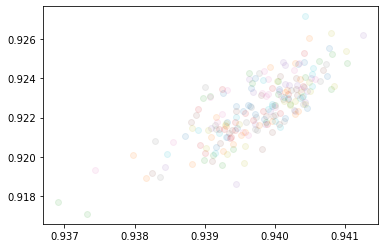

In [59]:
bstscr = 0
bstscr20 = 0
for i in tqdm(range(200)):
    rndwgts = np.random.rand(len(prfx2oofs))
    oofs = np.vstack(list(prfx2oofs.values())).T
    oofs.shape, rndwgts.shape
    oofswgted = np.average(oofs, axis=1, weights=rndwgts,)
    scr = roc_auc(ys, oofswgted)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofswgted[idx20])
    if scr>bstscr: 
        bstscr=scr
        rndwgts_bstscr=rndwgts
    if scr20>bstscr20: 
        bstscr20=scr20
        rndwgts_bstscr20=rndwgts
    plt.scatter(scr, scr20, alpha=.1)

In [67]:
print(bstscr)
rndwgts = rndwgts_bstscr
print(rndwgts)
oofs = np.vstack(list(prfx2oofs.values())).T
oofs.shape, rndwgts.shape
oofswgted = np.average(oofs, axis=1, weights=rndwgts,)
scr = roc_auc(ys, oofswgted)
scr20 = roc_auc(dftrn.target.iloc[idx20], oofswgted[idx20])
print(f'{scr:.4f},{scr20:.4f}')


0.941248024267695
[0.08202015 0.10578463 0.05051206 0.28325654 0.87513125 0.65841642
 0.45170245 0.77799004]
0.9412,0.9262


In [61]:
print(bstscr20)
rndwgts = rndwgts_bstscr20
oofs = np.vstack(list(prfx2oofs.values())).T
oofs.shape, rndwgts.shape
oofswgted = np.average(oofs, axis=1, weights=rndwgts,)
scr = roc_auc(ys, oofswgted)
scr20 = roc_auc(dftrn.target.iloc[idx20], oofswgted[idx20])
print(f'{scr:.4f},{scr20:.4f}')


0.9271806671625122
0.9404,0.9272


In [63]:
dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv') 

MelInf0726B2tta16 0.17577293900882407


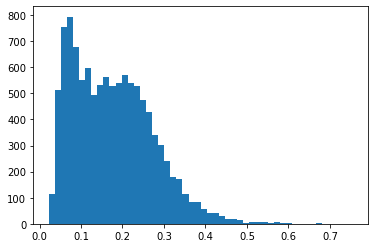

MelInf0727A1tta16 0.15930823437581493


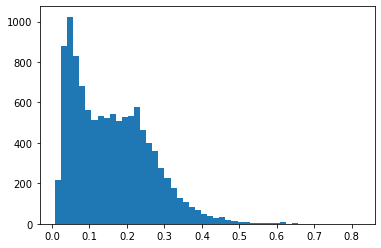

MelInf0727B1tta16 0.15253438272176548


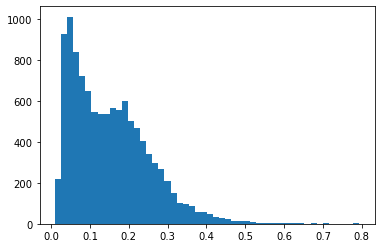

MelInf0726G2tta16 0.15595904496625135


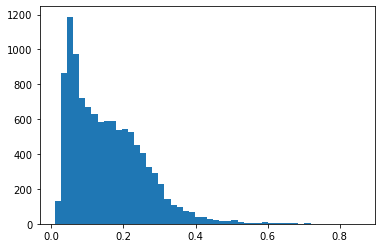

MelInf0726H2tta16 0.15230585584603645


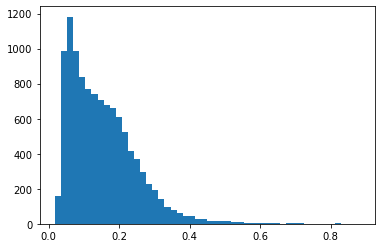

MelInf0729H1tta16 0.15282431964950818


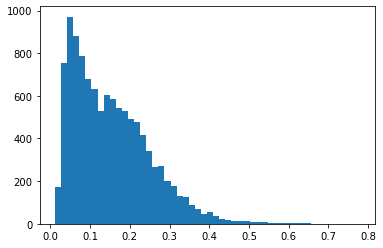

MelInf0729F1tta16 0.1487084176636413


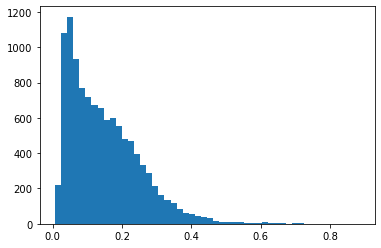

MelInf0729C1tta16 0.1371323752740608


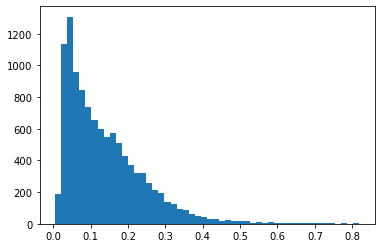

In [64]:
wgt_ttl=0
sub_esmb=np.zeros(len(dfsub))
for prfx,wgt in zip(prfxes, rndwgts_bstscr):
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    dfsubi = pd.read_csv(f'{p_out}/submission_{prfx}_avglast{param.LASTM}.csv')
    wgt_ttl+=wgt
    subi = dfsubi.target
    print(prfx, subi.mean())
    plt.hist(subi, bins=50);
    plt.show()
    sub_esmb+=subi
sub_esmb/=wgt_ttl

0.3758342930835653


,image_name,target
0,ISIC_0052060,0.106700
1,ISIC_0052349,0.107965
2,ISIC_0058510,0.149361


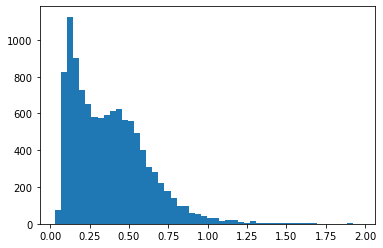

In [65]:
print(sub_esmb.mean())
dfsub.target = sub_esmb

display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [66]:
dfsub.to_csv(f'{p_esmb}/submission_search_{PRFX_ESMB}.csv', index=False)